In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
station = "Bats"

In [3]:
data = xr.load_dataset(f"./products/{station}_obs.zarr", engine="zarr")
data

<xarray.Dataset> Size: 13kB
Dimensions:    (time: 538, latitude: 1, longitude: 1, layer: 1)
Coordinates:
  * latitude   (latitude) float64 8B 31.6
  * layer      (layer) int64 8B 0
  * longitude  (longitude) float64 8B -64.2
  * time       (time) datetime64[ns] 4kB 1995-05-10 1995-05-11 ... 2022-12-13
Data variables:
    day        (time, latitude, longitude, layer) float64 4kB nan ... 0.362
    night      (time, latitude, longitude, layer) float64 4kB 1.108 nan ... 1.11
Attributes:
    creation date:  2024-10-13T20:03:40.209673
    layer:          epipelagic
    station:        Bats

# Remove outliers


In [4]:
q1 = data.quantile(0.25, dim="time")
q3 = data.quantile(0.75, dim="time")
iqr = q3 - q1

In [5]:
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

In [6]:
new_data = data.where((data > lower_bound) & (data < upper_bound))

# Remove observations when day > night


In [7]:
to_remove = new_data["day"].where(new_data["day"] > new_data["night"]).dropna("time").time
new_data = new_data.drop_sel(time=to_remove)
to_remove.to_series()

time
1996-11-05   1996-11-05
2005-07-19   2005-07-19
2006-01-29   2006-01-29
2007-11-14   2007-11-14
2009-07-15   2009-07-15
2010-06-23   2010-06-23
2015-09-12   2015-09-12
2016-10-19   2016-10-19
2018-01-15   2018-01-15
Name: time, dtype: datetime64[ns]

## DAY


Text(0.5, 1.0, 'Day observations')

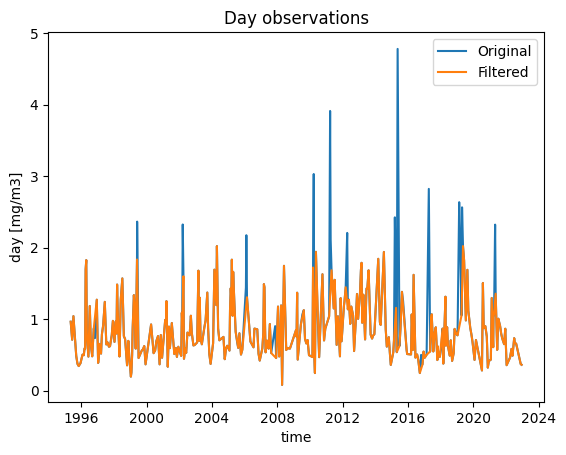

In [8]:
data.day.dropna("time").plot(label="Original")
new_data.day.dropna("time").plot(label="Filtered")
plt.legend()
plt.title("Day observations")

## NIGHT


Text(0.5, 1.0, 'Night observations')

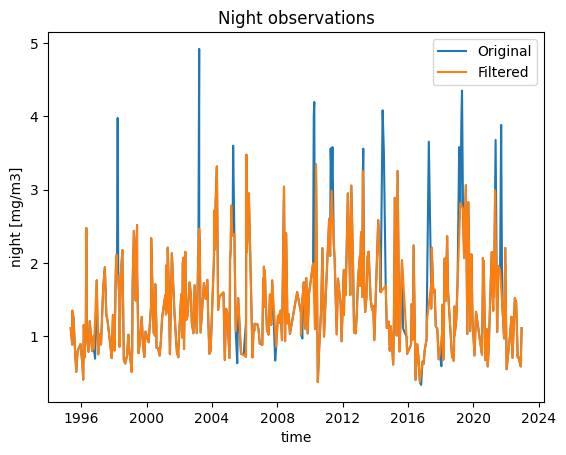

In [9]:
data.night.dropna("time").plot(label="Original")
new_data.night.dropna("time").plot(label="Filtered")
plt.legend()
plt.title("Night observations")

# Export


In [10]:
new_data.to_zarr(f"./products/{station}_obs_filtered.zarr")